In [50]:
import pandas as pd

pd.set_option("display.max_rows", None)
import cufflinks as cf
from textblob import TextBlob

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import matplotlib.pyplot as plt
import unidecode
from nltk import FreqDist
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [51]:
# df = pd.read_csv("preprocessed/pre-processed.csv")
df = pd.read_csv("all_together.csv")[["label", "text"]].rename(
    columns={"text": "preprocessed_news"}
)
# df.drop(columns=["index"], inplace=True)
df.sample(20).head()

,label,preprocessed_news
942,fake,briga sem fim jornalista ataca zeze di camargo...
4812,true,anitta abusa coreografias terceiro show planet...
2129,fake,"pai santo contratado pt: ""dilma aguentara dia ..."
6187,true,meu direto assunto abriu podcast comentaristas...
4234,true,eike perdeu empresas x tenta retomar negocios ...


In [52]:
def remove_accents(input_str):
    only_ascii = unidecode.unidecode(input_str)
    return only_ascii


stops = list(set(stopwords.words("portuguese")))
for i in range(0, len(stops)):
    stops[i] = remove_accents(stops[i])


def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stops]
    return " ".join(words)


import nltk

nltk.download("rslp")

df["preprocessed_news"] = df["preprocessed_news"].apply(remove_stopwords)
df["review_length"] = df["preprocessed_news"].apply(lambda x: len(str(x)))
df["word_count"] = df["preprocessed_news"].apply(lambda x: len(str(x).split()))

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Xinda\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [53]:
df["polarity"] = df["preprocessed_news"].map(
    lambda text: TextBlob(text).sentiment.polarity
)

In [54]:
df["polarity"].iplot(
    kind="hist",
    bins=50,
    xTitle="polarity",
    linecolor="black",
    yTitle="count",
    title="Sentiment Polarity Distribution",
)

In [55]:
df["review_length"].iplot(
    kind="hist",
    bins=100,
    xTitle="review length",
    linecolor="black",
    yTitle="count",
    title="Review Text Length Distribution",
)

In [56]:
df["word_count"].iplot(
    kind="hist",
    bins=100,
    xTitle="word count",
    linecolor="black",
    yTitle="count",
    title="Review Text Word Count Distribution",
)

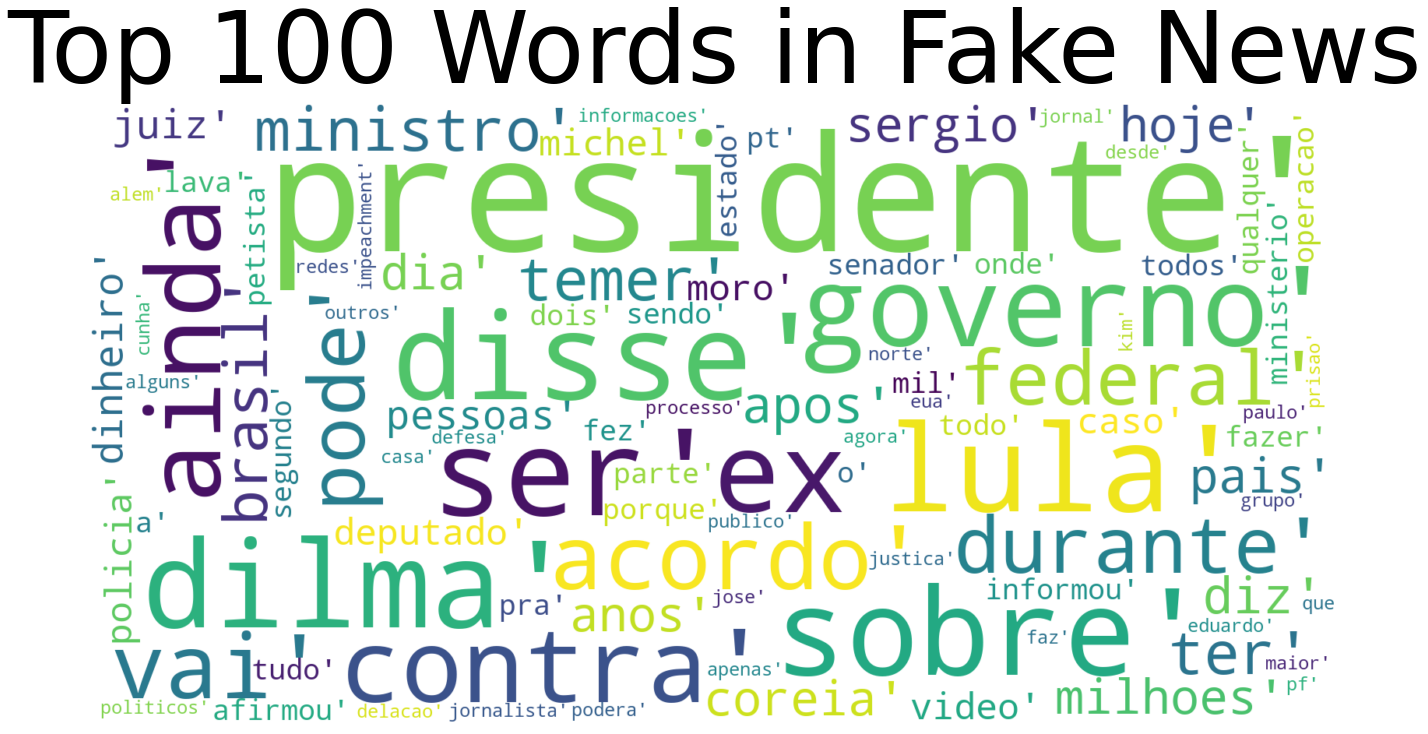

In [57]:
words = df.loc[df["label"] == "fake"]["preprocessed_news"]
allwords = []
for wordlist in words:
    allwords += wordlist.split()

mostcommon = FreqDist(allwords).most_common(100)

wordcloud = WordCloud(width=1600, height=800, background_color="white").generate(
    str(mostcommon)
)
fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top 100 Words in Fake News", fontsize=100)
plt.tight_layout(pad=0)
plt.show()

In [58]:
common_words_fake = get_top_n_words(
    df.loc[df["label"] == "fake"]["preprocessed_news"], 20
)
dfcf = pd.DataFrame(common_words_fake, columns=["preprocessed_news", "count"])
dfcf.groupby("preprocessed_news").sum()["count"].sort_values(ascending=False).iplot(
    kind="bar", yTitle="Count", linecolor="black", title="Top 20 words in fake news"
)

In [59]:
common_bigrams_fake = get_top_n_bigram(
    df.loc[df["label"] == "fake"]["preprocessed_news"], 20
)
dfbf = pd.DataFrame(common_bigrams_fake, columns=["preprocessed_news", "count"])
dfbf.groupby("preprocessed_news").sum()["count"].sort_values(ascending=False).iplot(
    kind="bar", yTitle="Count", linecolor="black", title="Top 20 bigrams in fake news"
)

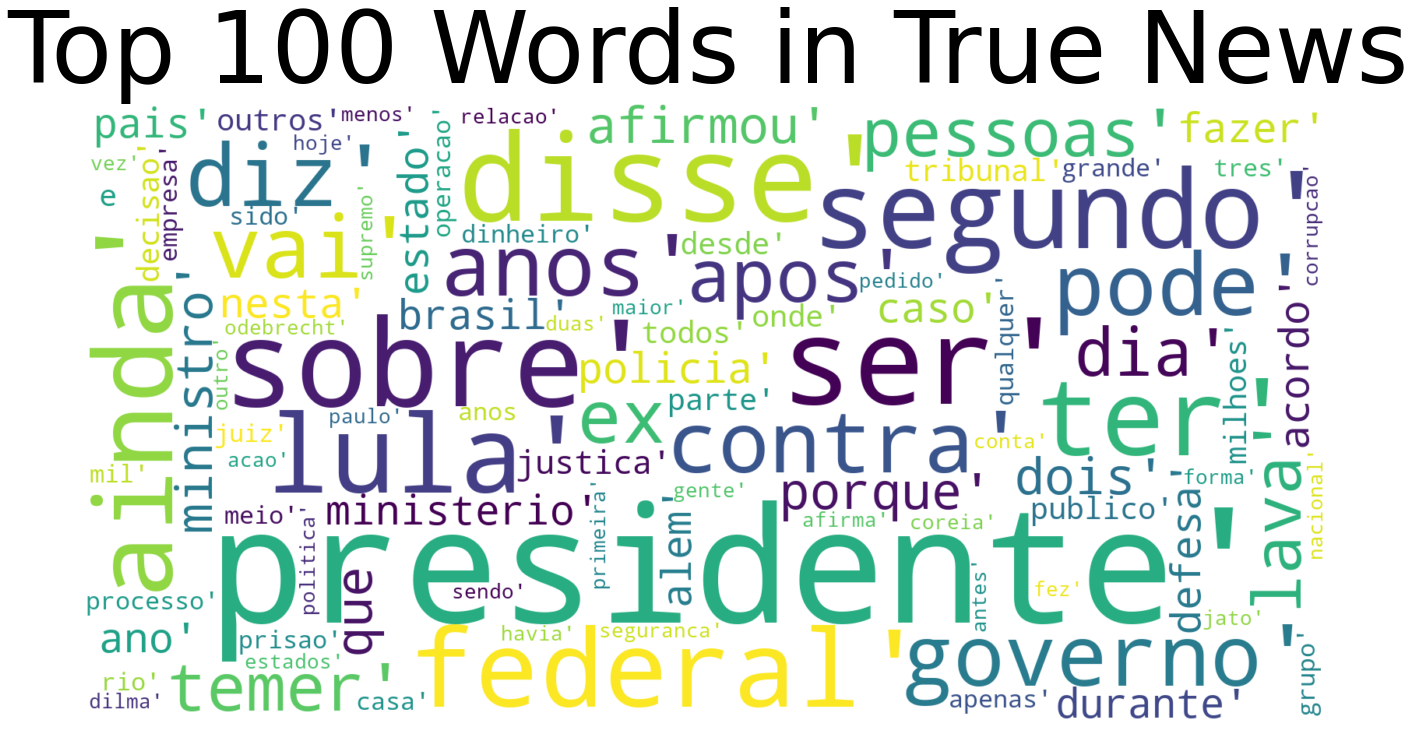

In [60]:
words_true = df.loc[df["label"] == "true"]["preprocessed_news"]
allwords_true = []
for wordlist_true in words_true:
    allwords_true += wordlist_true.split()

mostcommon_true = FreqDist(allwords_true).most_common(100)

wordcloud_true = WordCloud(width=1600, height=800, background_color="white").generate(
    str(mostcommon_true)
)
fig = plt.figure(figsize=(30, 10), facecolor="white")
plt.imshow(wordcloud_true, interpolation="bilinear")
plt.axis("off")
plt.title("Top 100 Words in True News", fontsize=100)
plt.tight_layout(pad=0)
plt.show()

In [61]:
common_words_true = get_top_n_words(
    df.loc[df["label"] == "true"]["preprocessed_news"], 20
)
dfct = pd.DataFrame(common_words_true, columns=["preprocessed_news", "count"])
dfct.groupby("preprocessed_news").sum()["count"].sort_values(ascending=False).iplot(
    kind="bar", yTitle="Count", linecolor="black", title="Top 20 words in true news"
)

In [62]:
common_bigrams_true = get_top_n_bigram(
    df.loc[df["label"] == "true"]["preprocessed_news"], 20
)
dfbt = pd.DataFrame(common_bigrams_true, columns=["preprocessed_news", "count"])
dfbt.groupby("preprocessed_news").sum()["count"].sort_values(ascending=False).iplot(
    kind="bar", yTitle="Count", linecolor="black", title="Top 20 bigrams in true news"
)

In [63]:
blob = TextBlob(str(df["preprocessed_news"]))
pos_df = pd.DataFrame(blob.tags, columns=["word", "pos"])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind="bar",
    xTitle="POS",
    yTitle="count",
    title="Top 20 Part-of-speech tagging for news corpus",
)